In [1]:
# Step 1: Imports
# Standard library
import os
import random

# Third-party packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.backends.cudnn as cudnn

# Optional: PyTorch Lightning
try:
    import pytorch_lightning as pl
    from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
except ImportError:
    pl = None
    print("PyTorch Lightning not available. Install if needed.")

PyTorch Lightning not available. Install if needed.


In [2]:
# Cell 0 — run if lightning not installed (Colab)
!pip install -q pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 39.8 MB/s eta 0:00:00


In [3]:
# Step 2
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_instances(sequence, window_size):
    #sequence: list of SoH
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)

    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
from sklearn.model_selection import train_test_split

def get_train_test(data_dict, name, window_size=8, test_size=0.2):
    data_sequence = data_dict[name]['SoH'].values  # ensure numpy array
    X, y = build_instances(data_sequence, window_size)

    # split 80/20
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=test_size, shuffle=False  # keep temporal order
    )
    return train_x, train_y, test_x, test_y


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    rmse = np.sqrt(np.mean((y_predict - y_test)**2))
    mae = mean_absolute_error(y_test, y_predict)
    mape = np.mean(np.abs((y_test - y_predict) / (y_test + 1e-8))) * 100
    r2 = r2_score(y_test, y_predict)
    return [rmse, mae, mape, r2]


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Path jaha tumne rar ka extracted folder upload kiya
data_path = "/content/drive/MyDrive/DeepLearningProject/"

Mounted at /content/drive


In [5]:
# Step 3
import os
import glob
import numpy as np
import pandas as pd

# ---------------------------
# CONFIG
# ---------------------------
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
dir_path = "/content/drive/MyDrive/Dataset/"
npy_path = os.path.join(dir_path, "CALCE.npy")


# ---------------------------
# Outlier removal (simple + safe)
# ---------------------------
def drop_outlier(values, sigma=3):
    values = np.array(values)
    mean, std = np.mean(values), np.std(values)
    mask = np.abs(values - mean) < sigma * std
    return np.where(mask)[0]


# ---------------------------
# Safe ΔQ (SoH) estimation
# Uses official CALCE style: capacity @ 3.8V → capacity @ 3.4V
# ---------------------------
def compute_delta_Q(voltage, capacity):
    voltage = np.array(voltage)
    capacity = np.array(capacity)

    # find closest points
    idx1 = np.argmin(np.abs(voltage - 3.8))
    idx2 = np.argmin(np.abs(voltage - 3.4))

    # ensure index order
    if idx2 <= idx1:
        return np.nan

    return capacity[idx2] - capacity[idx1]


# ---------------------------
# MAIN PROCESSING
# ---------------------------
if os.path.exists(npy_path):
    print("✔ CALCE.npy found. Loading preprocessed dataset...")
    Battery = np.load(npy_path, allow_pickle=True).item()

else:
    print("⚙ Processing CALCE Excel files...")
    Battery = {}

    for name in Battery_list:
        print(f"\n📌 Processing dataset: {name}")

        # --------- Get all files & sort by earliest timestamp ---------
        file_paths = glob.glob(os.path.join(dir_path, name, "*.xlsx"))
        timestamps = []

        for p in file_paths:
            df0 = pd.read_excel(p, sheet_name=1)
            timestamps.append(pd.to_datetime(df0['Date_Time']).min())

        file_paths = np.array(file_paths)[np.argsort(timestamps)]  # sorted

        # --------- Empty storage ---------
        cap_list = []
        soh_list = []
        ir_list = []
        ccct_list = []
        cvct_list = []

        # --------- Read each file sequentially ---------
        for p in file_paths:
            print(" → File:", p)
            df = pd.read_excel(p, sheet_name=1)

            # Cycle order preserved
            cycles = df['Cycle_Index'].unique()

            for c in cycles:
                df_cyc = df[df['Cycle_Index'] == c]

                # ----- Charge steps -----
                df_cc = df_cyc[df_cyc['Step_Index'] == 2]
                df_cv = df_cyc[df_cyc['Step_Index'] == 4]

                if not df_cc.empty:
                    cc_time = df_cc['Test_Time(s)']
                    ccct_list.append(cc_time.max() - cc_time.min())
                else:
                    ccct_list.append(np.nan)

                if not df_cv.empty:
                    cv_time = df_cv['Test_Time(s)']
                    cvct_list.append(cv_time.max() - cv_time.min())
                else:
                    cvct_list.append(np.nan)

                # ----- Discharge step -----
                df_d = df_cyc[df_cyc['Step_Index'] == 7]

                if df_d.empty:
                    cap_list.append(np.nan)
                    soh_list.append(np.nan)
                    ir_list.append(np.nan)
                    continue

                V = df_d['Voltage(V)'].to_numpy()
                I = df_d['Current(A)'].to_numpy()
                T = df_d['Test_Time(s)'].to_numpy()
                R = df_d['Internal_Resistance(Ohm)'].to_numpy()

                # Ensure monotonic time
                idx_sort = np.argsort(T)
                T, I, V, R = T[idx_sort], I[idx_sort], V[idx_sort], R[idx_sort]

                # ----- Compute capacity -----
                dt = np.diff(T)               # time differences
                I_mid = I[1:]                 # align lengths
                cap_curve = np.cumsum(I_mid * dt) / 3600  # A*s → Ah
                total_cap = cap_curve[-1] if len(cap_curve) > 0 else np.nan
                cap_list.append(total_cap)

                # ----- Compute ΔQ SoH -----
                soh = compute_delta_Q(V[1:], cap_curve)
                soh_list.append(soh)

                # ----- Internal resistance -----
                ir_list.append(np.mean(R))

        # ---------------------------
        # convert to numpy arrays
        # ---------------------------
        cap_list = np.array(cap_list)
        soh_list = np.array(soh_list)
        ir_list = np.array(ir_list)
        ccct_list = np.array(ccct_list)
        cvct_list = np.array(cvct_list)

        # ---------------------------
        # Outlier removal – applied to capacity only
        # then filter all arrays
        # ---------------------------
        idx = drop_outlier(cap_list, sigma=3)

        df_result = pd.DataFrame({
            'cycle': np.arange(1, len(idx) + 1),
            'capacity': cap_list[idx],
            'SoH': soh_list[idx],
            'resistance': ir_list[idx],
            'CCCT': ccct_list[idx],
            'CVCT': cvct_list[idx]
        })

        Battery[name] = df_result

    # Save
    np.save(npy_path, Battery)
    print("\n💾 Saved cleaned dataset as CALCE.npy")

✔ CALCE.npy found. Loading preprocessed dataset...


In [6]:
# Step 4 — Inspect a specific battery
import numpy as np
import pandas as pd

# Load processed dataset
CALCE_PATH = "/content/drive/MyDrive/Dataset/CALCE.npy"
Battery = np.load(CALCE_PATH, allow_pickle=True).item()

# Show available battery names
print("📌 Available Batteries:", list(Battery.keys()))

# Choose one battery (change name if needed)
battery_name = 'CS2_36'

# Safety check
if battery_name not in Battery:
    raise ValueError(f"Battery '{battery_name}' not found. Available: {list(Battery.keys())}")

print(f"\n🔍 Preview of {battery_name}:")
display(Battery[battery_name].head())   # nicer view in Colab

📌 Available Batteries: ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

🔍 Preview of CS2_36:


,cycle,capacity,SoH,resistance,CCCT,CVCT
0,1.0,1.133807,0.825405,0.091628,6671.683200,2212.998635
1,2.0,1.133413,0.825388,0.091628,6666.933312,2204.373626
2,3.0,1.132829,0.825391,0.090817,6662.682287,2201.186076
3,4.0,1.127033,0.816240,0.088546,6656.650722,2225.592597
4,5.0,1.126712,0.807060,0.087494,6693.788570,2052.849153


/tmp/ipython-input-304847407.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


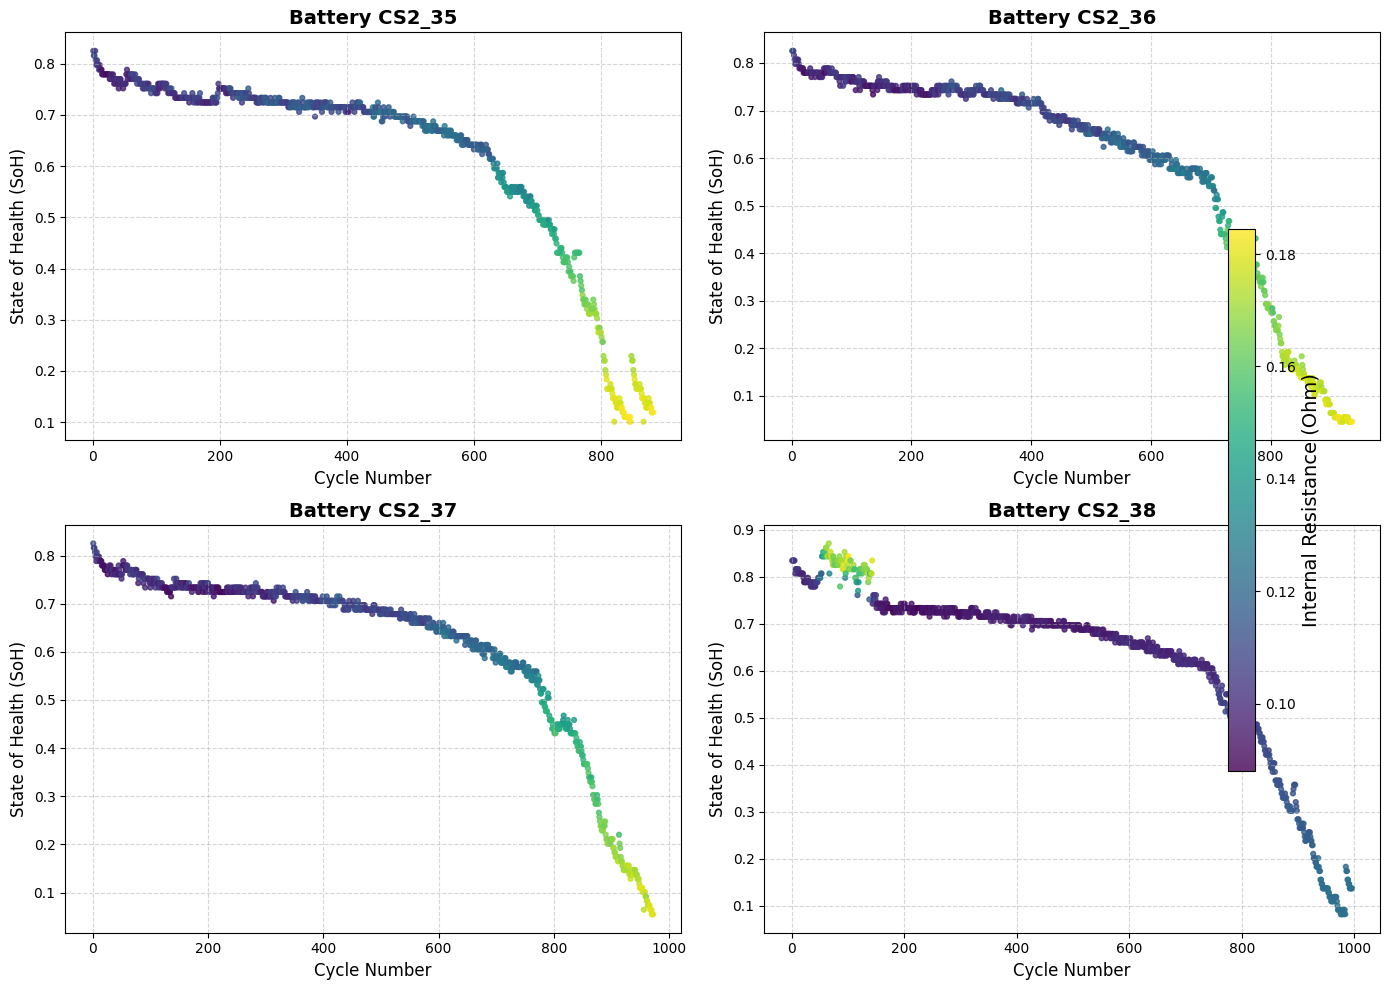

In [7]:
# Step 5: SoH Plots
import matplotlib.pyplot as plt

# Batteries you want to plot
battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # flatten to 1D for easier looping

for i, name in enumerate(battery_list):
    battery = Battery[name]

    # Scatter plot of SoH vs Cycle, colored by Resistance
    sc = axes[i].scatter(
        battery['cycle'],
        battery['SoH'],
        c=battery['resistance'],
        s=12,
        cmap='viridis',
        alpha=0.8
    )

    axes[i].set_title(f'Battery {name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cycle Number', fontsize=12)
    axes[i].set_ylabel('State of Health (SoH)', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Add one shared colorbarz
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label('Internal Resistance (Ohm)', fontsize=14)

plt.tight_layout()
plt.show()

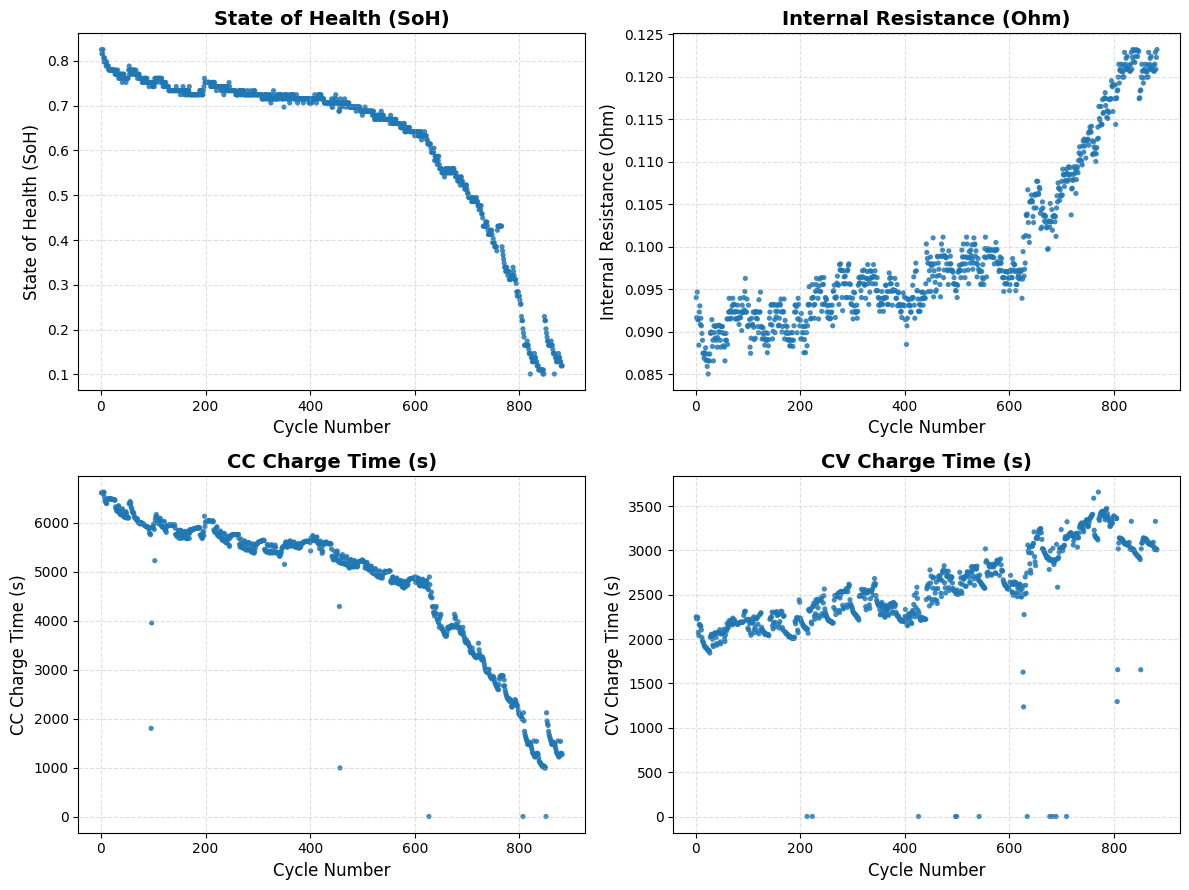

In [8]:
# Step 6 — Visualizing SoH, Resistance, CCCT, CVCT for one battery
import matplotlib.pyplot as plt

# Choose a battery
battery_name = 'CS2_35'

# Safety check
if battery_name not in Battery:
    raise KeyError(f"Battery '{battery_name}' not found. Available: {list(Battery.keys())}")

df = Battery[battery_name]

# Parameters to plot
columns = ['SoH', 'resistance', 'CCCT', 'CVCT']
labels = [
    'State of Health (SoH)',
    'Internal Resistance (Ohm)',
    'CC Charge Time (s)',
    'CV Charge Time (s)'
]

plt.figure(figsize=(12, 9))

for i, (col, label) in enumerate(zip(columns, labels), start=1):
    plt.subplot(2, 2, i)
    plt.scatter(
        df['cycle'],
        df[col],
        s=14,
        alpha=0.85,
        edgecolors='none'
    )

    plt.xlabel('Cycle Number', fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.title(label, fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

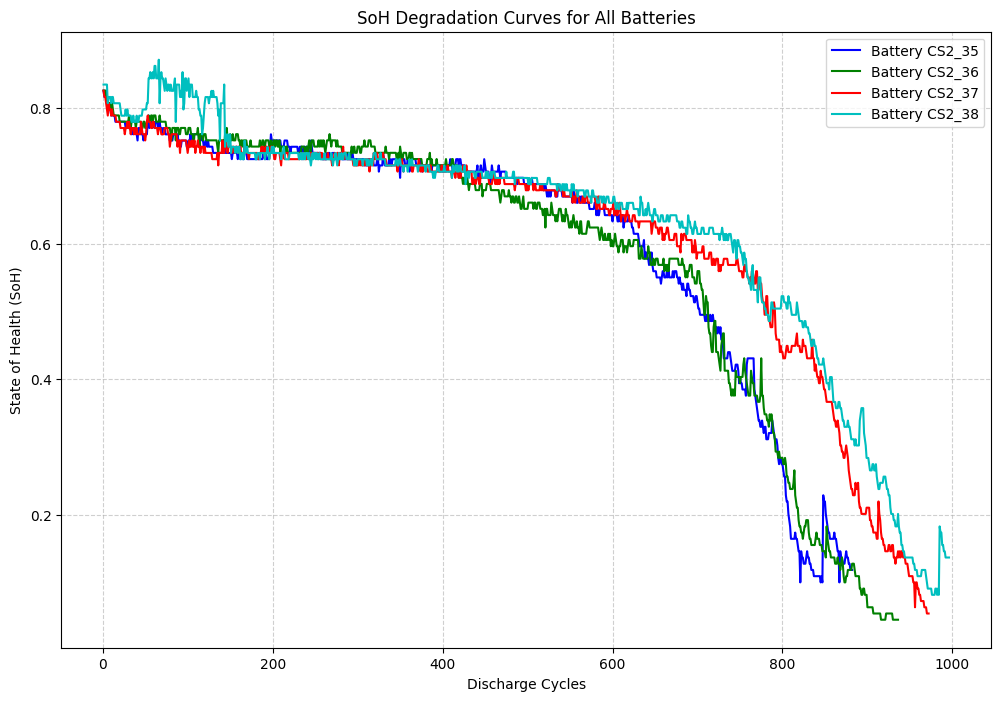

In [9]:
# Step 7: SoH degradation curves

battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

fig, ax = plt.subplots(figsize=(12, 8))
color_list = ['b-', 'g-', 'r-', 'c-']  # clean line formats

for name, color in zip(battery_list, color_list):
    df_result = Battery[name]

    # Plot SoH degradation
    ax.plot(df_result['cycle'], df_result['SoH'], color, label=f'Battery {name}')

ax.set(
    xlabel='Discharge Cycles',
    ylabel='State of Health (SoH)',
    title='SoH Degradation Curves for All Batteries'
)

ax.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [10]:
# Pick one battery and inspect its columns
df = Battery['CS2_36']
print(df.head())
print("\nAvailable columns:", df.columns.tolist())

   cycle  capacity       SoH  resistance         CCCT         CVCT
0    1.0  1.133807  0.825405    0.091628  6671.683200  2212.998635
1    2.0  1.133413  0.825388    0.091628  6666.933312  2204.373626
2    3.0  1.132829  0.825391    0.090817  6662.682287  2201.186076
3    4.0  1.127033  0.816240    0.088546  6656.650722  2225.592597
4    5.0  1.126712  0.807060    0.087494  6693.788570  2052.849153

Available columns: ['cycle', 'capacity', 'SoH', 'resistance', 'CCCT', 'CVCT']


In [11]:
# Step 8 — Corrected Sequence Preparation for TCN + Transformer

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

df = Battery['CS2_36']

# Remove invalid feature "capacity" and avoid SoH as input
feature_cols = ['cycle', 'resistance', 'CCCT', 'CVCT']
target_col   = 'SoH'

features = df[feature_cols].values
target   = df[target_col].values

# Normalize
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# ----- Create sequences -----
SEQ_LEN = 20  # important hyperparameter

X, Y = [], []
for i in range(len(features_scaled) - SEQ_LEN):
    X.append(features_scaled[i : i+SEQ_LEN])
    Y.append(target[i+SEQ_LEN])    # predict next SoH

X = np.array(X)
Y = np.array(Y)

# Train-test split without shuffle
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = Y[:split_idx], Y[split_idx:]

# To PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=32, shuffle=False
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=32, shuffle=False
)

print("Train shape:", X_train_tensor.shape)
print("Test shape:", X_test_tensor.shape)

Train shape: torch.Size([732, 20, 4])
Test shape: torch.Size([184, 20, 4])


In [12]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim


# ---------- Positional Encoding ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        # x: (batch, seq, d_model)
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x


# ---------- Full Model ----------
class TCNTransformerSoH_Pyramid(pl.LightningModule):
    def __init__(self, n_features=4, hidden_dim=64,
                 n_dilations=[1, 2, 4], nhead=8, lr=1e-4):

        super().__init__()
        self.save_hyperparameters()

        assert hidden_dim % nhead == 0
        assert hidden_dim % len(n_dilations) == 0

        in_ch = n_features
        out_ch = hidden_dim // len(n_dilations)

        # ----- Multi-Scale TCN -----
        self.tcn_branches = nn.ModuleList()
        for dilation in n_dilations:
            branch = nn.Sequential(
                nn.Conv1d(in_ch, out_ch, kernel_size=3, dilation=dilation, padding=dilation),
                nn.ReLU(),
                nn.GroupNorm(1, out_ch),
                nn.Conv1d(out_ch, out_ch, kernel_size=3, dilation=dilation, padding=dilation),
                nn.ReLU(),
                nn.GroupNorm(1, out_ch)
            )
            self.tcn_branches.append(branch)

        # ----- Transformer -----
        self.pos_enc = PositionalEncoding(hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # ----- Attention Pooling -----
        self.attn = nn.Linear(hidden_dim, 1)

        # ----- MLP Head -----
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

        self.loss_fn = nn.MSELoss()
        self.lr = lr

    def forward(self, x):
        # x: (batch, seq, features)
        x = x.permute(0, 2, 1)  # (B, F, S)

        tcn_outs = [branch(x) for branch in self.tcn_branches]  # list of (B, C, S)
        x = torch.cat(tcn_outs, dim=1)  # (B, hidden_dim, S)

        x = x.permute(0, 2, 1)  # (B, S, hidden_dim)

        x = self.pos_enc(x)
        x = self.transformer(x)

        # Attention pooling
        weights = torch.softmax(self.attn(x), dim=1)
        pooled = torch.sum(weights * x, dim=1)

        return self.fc(pooled).squeeze(-1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)


print("🔥 Model ready: TCNTransformerSoH_Pyramid (Corrected)")

🔥 Model ready: TCNTransformerSoH_Pyramid (Corrected)


In [13]:
# Step A: Normalize Features
from sklearn.preprocessing import StandardScaler

# Select feature columns
feature_cols = ['cycle', 'capacity', 'resistance', 'CCCT', 'CVCT']

# Scale each battery dataframe
scaler = StandardScaler()
for name in Battery:
    df = Battery[name]
    df[feature_cols] = scaler.fit_transform(df[feature_cols])
    Battery[name] = df  # overwrite back

In [14]:
# Step B: Reduce Learning Rate
model = TCNTransformerSoH_Pyramid(n_features=5, hidden_dim=72, nhead=8, lr=1e-4)

In [15]:
# Step C: Check for NaNs
# Verify no missing values remain
for name in Battery:
    print(f"{name}:\n", Battery[name].isna().sum(), "\n")

CS2_35:
 cycle          0
capacity       0
SoH            0
resistance     0
CCCT           0
CVCT          18
dtype: int64 

CS2_36:
 cycle          0
capacity       0
SoH            0
resistance     0
CCCT           0
CVCT          13
dtype: int64 

CS2_37:
 cycle          0
capacity       0
SoH            0
resistance     0
CCCT           0
CVCT          14
dtype: int64 

CS2_38:
 cycle          0
capacity       0
SoH            0
resistance     0
CCCT           0
CVCT          10
dtype: int64 



In [16]:
for name in Battery:
    Battery[name] = Battery[name].dropna()

In [17]:
# Step D: Check SoH ranges and NaNs
for name in Battery:
    soh = Battery[name]['SoH']
    print(f"{name}: min={soh.min():.4f}, max={soh.max():.4f}, NaNs={soh.isna().sum()}")

CS2_35: min=0.1008, max=0.8252, NaNs=0
CS2_36: min=0.0458, max=0.8254, NaNs=0
CS2_37: min=0.0550, max=0.8253, NaNs=0
CS2_38: min=0.0825, max=0.8708, NaNs=0


In [18]:
# === STEP E: Rebuild windowed dataset and fit scalers (run first) ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Settings
Battery_list = list(Battery.keys())   # uses your cleaned Battery dict
feature_cols = ['cycle', 'capacity', 'resistance', 'CCCT', 'CVCT']
target_col = 'SoH'
WINDOW = 20           # change if you want longer history
BATCH_SIZE = 64
RANDOM_SEED = 42

# 1) Build windows
X_windows = []
y_values = []
for name in Battery_list:
    df = Battery[name].reset_index(drop=True)
    vals = df[feature_cols + [target_col]].values  # shape (T, 6)
    T = len(vals)
    for i in range(T - WINDOW):
        X_windows.append(vals[i:i+WINDOW, :len(feature_cols)])   # (WINDOW, n_features)
        y_values.append(vals[i+WINDOW, len(feature_cols)])       # SoH next step

X = np.array(X_windows, dtype=np.float32)   # (N, WINDOW, n_features)
y = np.array(y_values, dtype=np.float32)   # (N,)

print("Built windows:", X.shape, y.shape)

# 2) Train/Val split (shuffle True is OK because many windows)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)
print("Train/Val sizes:", X_train.shape[0], X_val.shape[0])

# 3) Fit scalers on TRAIN only
scaler_X = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])          # (N_train*WINDOW, n_features)
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)    # (N_train, WINDOW, n_features)

# transform validation and full test with same scaler
X_val_flat = X_val.reshape(-1, X_val.shape[-1])
X_val_scaled = scaler_X.transform(X_val_flat).reshape(X_val.shape)

# scale target (SoH) to [0,1]
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).flatten()

# 4) Convert to tensors and dataloaders (keep shape (batch, seq_len, features))
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t   = torch.tensor(y_val_scaled, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Dataloaders ready. Example batch shapes:")
xb, yb = next(iter(train_loader))
print("xb:", xb.shape, "yb:", yb.shape)   # should be (BATCH, WINDOW, n_features) and (BATCH,)

Built windows: (3651, 20, 5) (3651,)
Train/Val sizes: 2920 731
Dataloaders ready. Example batch shapes:
xb: torch.Size([64, 20, 5]) yb: torch.Size([64])


In [19]:
# STEP 10: Training
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Instantiate model: ensure hidden_dim divisible by nhead and len(n_dilations)
model = TCNTransformerSoH_Pyramid(
    n_features=X.shape[-1],
    hidden_dim=72,
    nhead=8,
    lr=1e-4
)

# Callbacks
checkpoint_cb = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="tcntf-best"
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=12,
    mode="min",
    verbose=True
)

# Trainer
trainer = Trainer(
    max_epochs=80,
    accelerator="auto",
    devices=1,
    gradient_clip_val=1.0,
    callbacks=[checkpoint_cb, earlystop_cb],
    log_every_n_steps=10
)

# Train
trainer.fit(model, train_loader, val_loader)

print("Training finished. Best checkpoint:", checkpoint_cb.best_model_path)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ tcn_branches │ ModuleList         │  6.7 K │ train │     0 │
│ 1 │ pos_enc      │ PositionalEncoding │      0 │ train │     0 │
│ 2 │ transformer  │ TransformerEncoder │  636 K │ train │     0 │
│ 3 │ attn         │ Linear             │     73 │ train │     0 │
│ 4 │ fc           │ Sequential         │  4.7 K │ train │     0 │
│ 5 │ loss_fn      │ MSELoss            │      0 │ train │     0 │
└───┴──────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 648 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 648 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 52                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.002
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
INFO:pytorch_lightning.callbacks.ear

Training finished. Best checkpoint: /content/lightning_logs/version_0/checkpoints/tcntf-best.ckpt


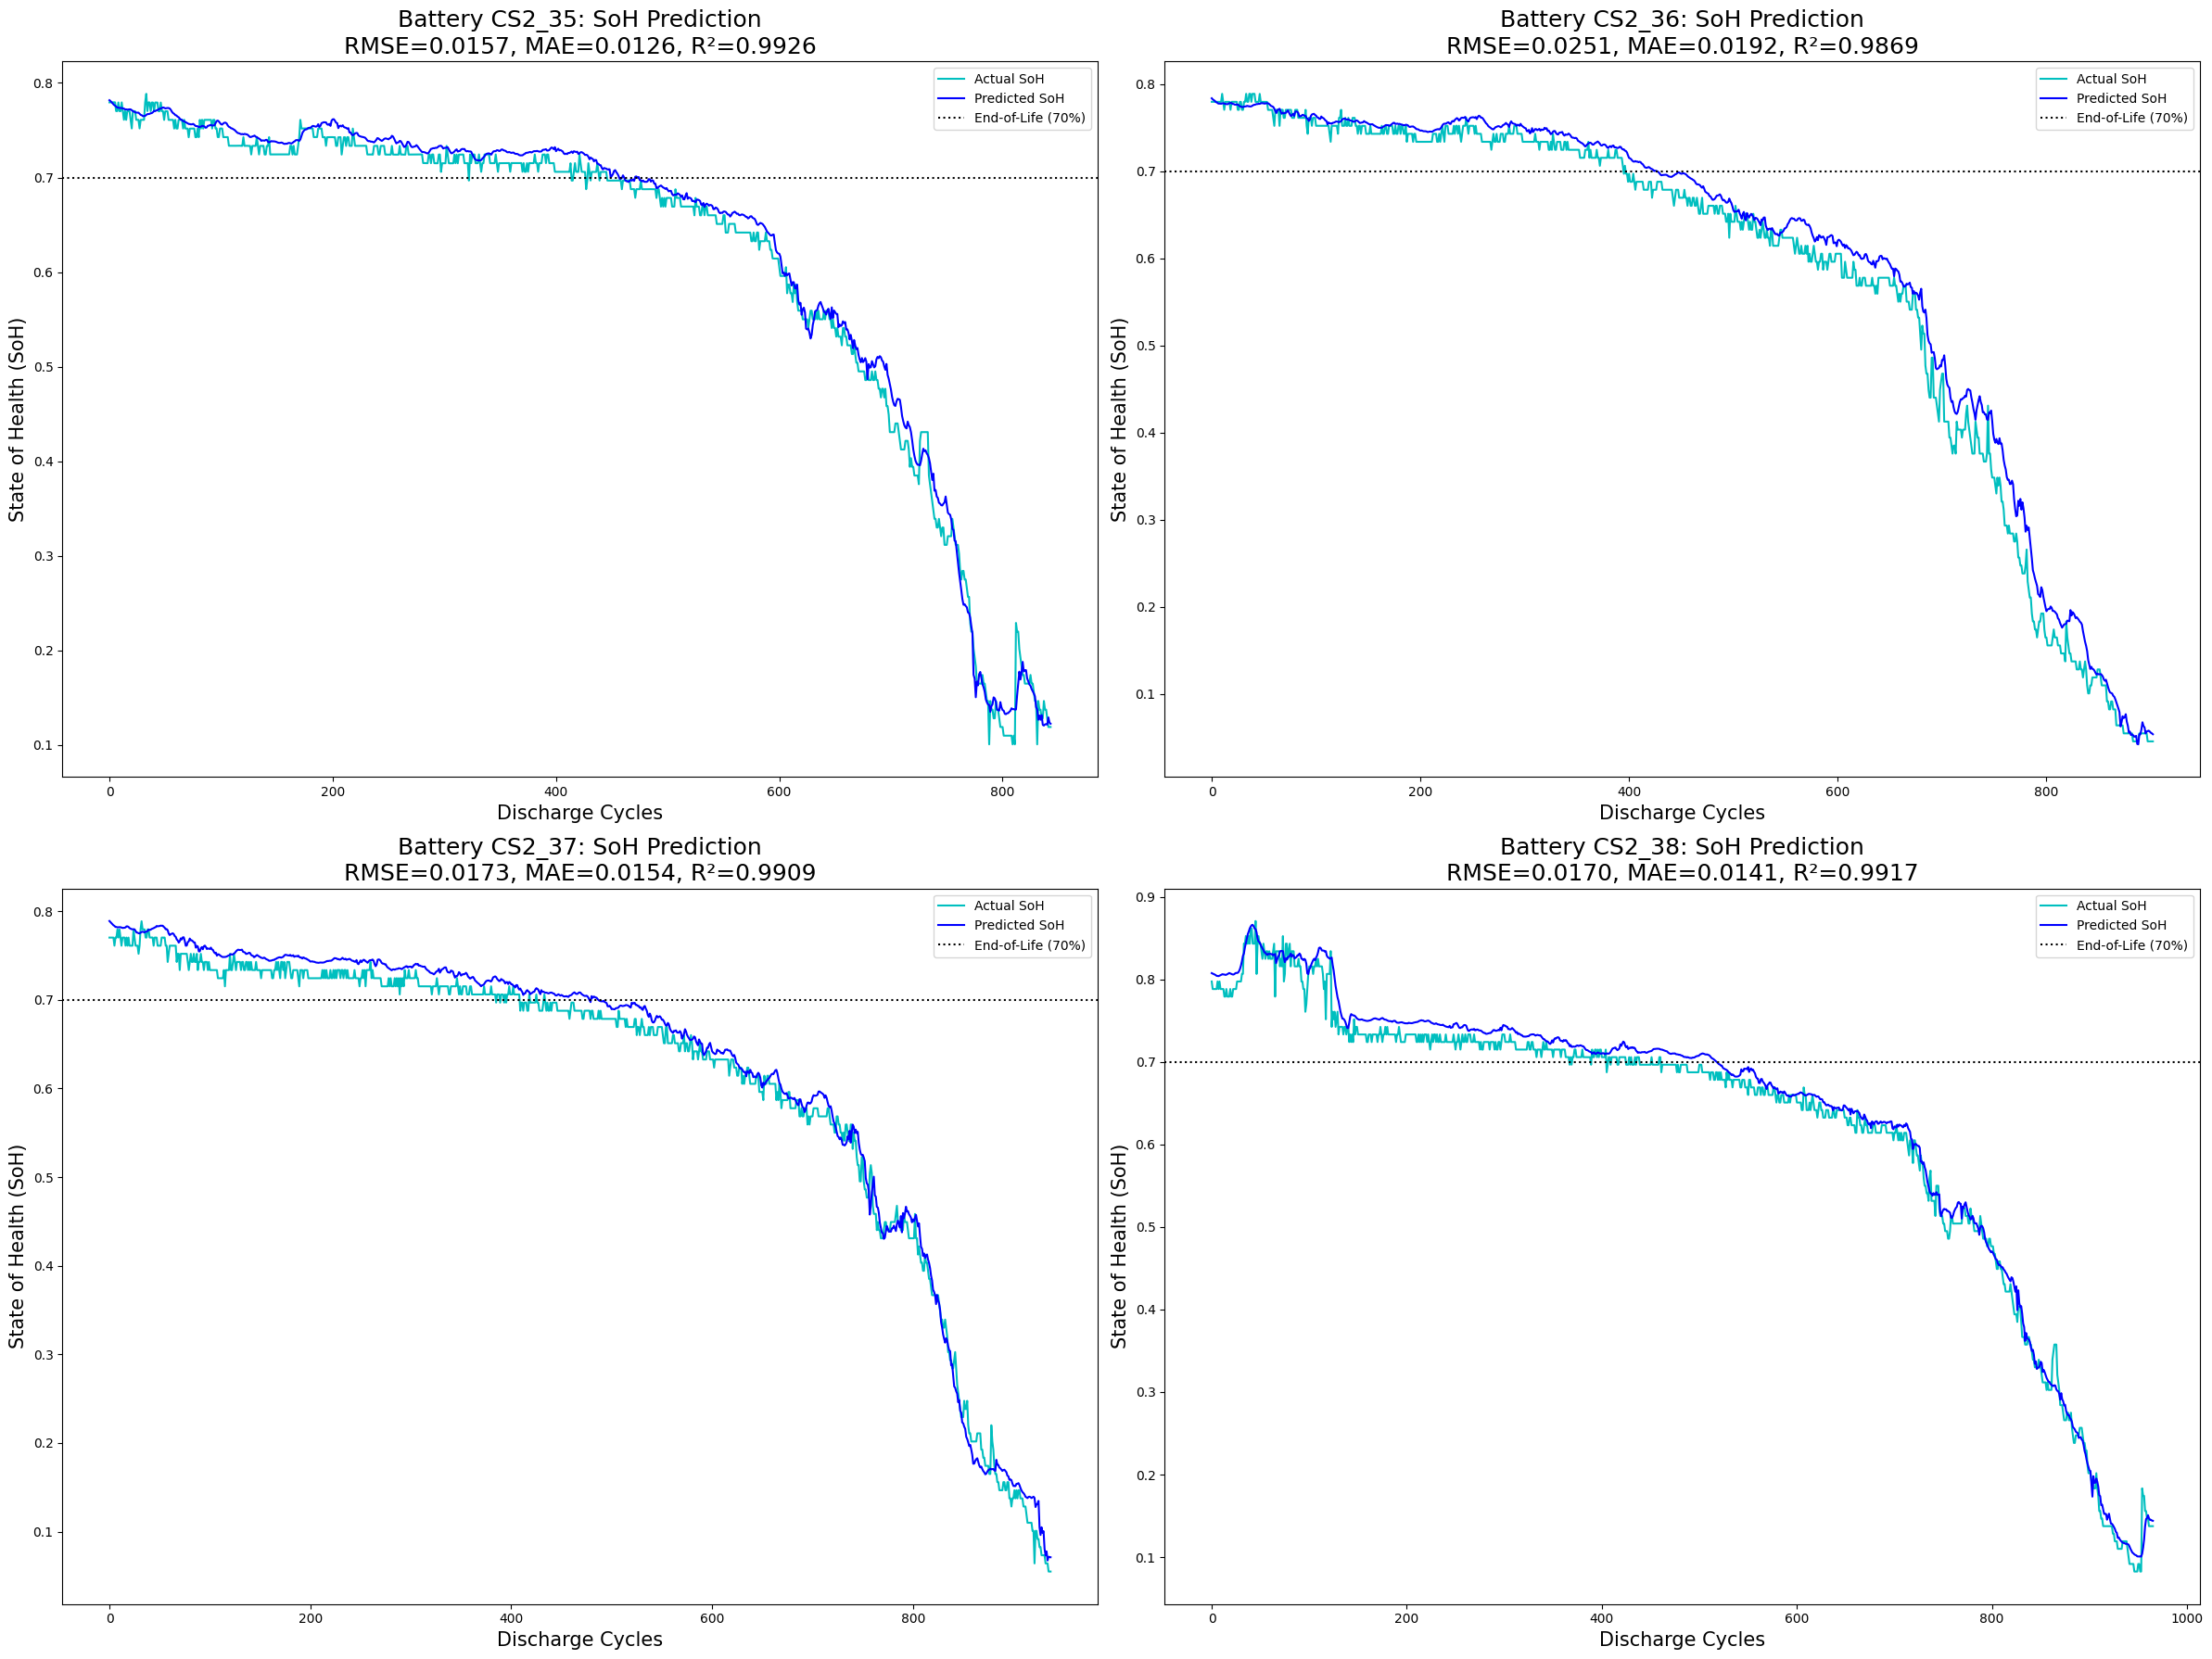

In [20]:
# STEP 11: Predictions and Visualization (aligned with training pipeline) ===
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

model.eval()
prediction_list = []
test_list = []
metrics = {}

window_size = X_train.shape[1]   # same as training
n_features = X_train.shape[2]    # 5 features: cycle, capacity, resistance, CCCT, CVCT

with torch.no_grad():
    for name in Battery_list:
        df = Battery[name].reset_index(drop=True)

        # Extract features + target
        features = df[feature_cols].values.astype(np.float32)
        target   = df[target_col].values.astype(np.float32)

        # Scale features using the training scaler
        features_scaled = scaler_X.transform(features)

        preds, tests = [], []

        for i in range(len(df) - window_size):
            x_input = features_scaled[i:i+window_size].reshape(1, window_size, n_features)
            x_tensor = torch.tensor(x_input, dtype=torch.float32)

            # Predict scaled SoH
            y_pred_scaled = model(x_tensor).item()
            # Inverse transform to real SoH
            y_pred_soh = scaler_y.inverse_transform([[y_pred_scaled]])[0, 0]
            preds.append(y_pred_soh)

            # True SoH
            y_true_soh = target[i+window_size]
            tests.append(y_true_soh)

        prediction_list.append(preds)
        test_list.append(tests)

        # 📊 Error Metrics
        rmse = np.sqrt(mean_squared_error(tests, preds))
        mae = mean_absolute_error(tests, preds)
        r2 = r2_score(tests, preds)
        metrics[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}

# 📊 Visualization
fig, ax = plt.subplots(2, 2, figsize=(24, 18))

for idx, name in enumerate(Battery_list[:4]):  # plot first 4 batteries
    i, j = divmod(idx, 2)
    ax[i][j].plot(test_list[idx], 'c', label='Actual SoH')
    ax[i][j].plot(prediction_list[idx], 'b', label='Predicted SoH')
    ax[i][j].axhline(y=0.7, color='black', linestyle=':', label='End-of-Life (70%)')

    rmse, mae, r2 = metrics[name]["RMSE"], metrics[name]["MAE"], metrics[name]["R²"]
    ax[i][j].set_title(
        f"Battery {name}: SoH Prediction\nRMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}",
        fontsize=18
    )
    ax[i][j].set_xlabel('Discharge Cycles', fontsize=15)
    ax[i][j].set_ylabel('State of Health (SoH)', fontsize=15)
    ax[i][j].legend()

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Custom MAPE Function ---
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE).

    A small epsilon is added to y_true to prevent division by zero,
    especially when SoH approaches zero.
    """
    epsilon = 1e-10

    # Calculate the absolute percentage error
    ape = np.abs((y_true - y_pred) / (y_true + epsilon))

    # Return as a percentage (0 to 100)
    return np.mean(ape) * 100

In [22]:
# --- 2. Create a Dictionary of Actual and Predicted Data ---
# Map the battery name to a tuple: (Actual SoH, Predicted SoH)
# Using the test_list and prediction_list created in STEP 11
battery_data = {
    name: (test_list[i], prediction_list[i])
    for i, name in enumerate(Battery_list)
}

# --- 3. Calculate and Store All Metrics ---
results = {}

for battery, (y_true, y_pred) in battery_data.items():

    # Ensure all inputs are NumPy arrays for consistent calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Store the results
    results[battery] = {
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'MAPE': mape
    }

# --- 4. Display Results as a Pandas DataFrame ---
df_results = pd.DataFrame.from_dict(results, orient='index')

# Format the output to 4 decimal places for consistency
df_results_formatted = df_results.round(4)

print("--- Comprehensive Model Performance Metrics ---")
display(df_results_formatted)

--- Comprehensive Model Performance Metrics ---


,RMSE,MAE,R^2,MAPE
CS2_35,0.0157,0.0126,0.9926,2.9498
CS2_36,0.0251,0.0192,0.9869,5.8496
CS2_37,0.0173,0.0154,0.9909,3.6253
CS2_38,0.0170,0.0141,0.9917,2.8289


In [23]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def generate_results_csv(actual_values, predicted_values, filename="model_results.csv"):
    """
    Creates a DataFrame with 'Actual', 'Predicted', and 'Error' columns
    and saves it to a CSV file. It also calculates and saves key performance
    metrics (MSE, MAE, R2) to a separate text file.

    Args:
        actual_values (np.array or list): The true/ground-truth target values (y_test).
        predicted_values (np.array or list): The values predicted by the model.
        filename (str): The name of the output CSV file.
    """

    # 1. Ensure inputs are NumPy arrays and flatten them if they are multi-dimensional
    # This handles common issues where model predictions might be shape (N, 1)
    actual_values = np.array(actual_values).flatten()
    predicted_values = np.array(predicted_values).flatten()

    # Check for array length mismatch
    if len(actual_values) != len(predicted_values):
        print("Error: Actual and Predicted value arrays must have the same length.")
        return

    # 2. Calculate the difference (Error)
    # Error is typically calculated as Actual - Predicted
    error_values = actual_values - predicted_values

    # 3. Create the DataFrame
    data = {
        'Actual': actual_values,
        'Predicted': predicted_values,
        'Error': error_values
    }
    df = pd.DataFrame(data)

    # 4. Save the main data to CSV
    # index=False ensures the row numbers are not written to the file
    df.to_csv(filename, index=False)
    print(f"\n[SUCCESS] Successfully generated the main data file: {filename}")
    print("\n--- Statistical Summary ---")
    print(df[['Actual', 'Predicted', 'Error']].describe())

    # 5. Calculate and save overall metrics for performance reporting
    try:
        # Calculate key metrics using sklearn (recommended for academic work)
        mse = mean_squared_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        r2 = r2_score(actual_values, predicted_values)

        # Create a separate summary file with metrics
        summary_data = {
            'Metric': ['MSE', 'MAE', 'R2'],
            'Value': [f"{mse:.4f}", f"{mae:.4f}", f"{r2:.4f}"]
        }
        summary_df = pd.DataFrame(summary_data)
        summary_filename = filename.replace('.csv', '_metrics.txt')

        with open(summary_filename, 'w') as f:
            f.write("--- Model Performance Metrics ---\n")
            f.write(summary_df.to_string(index=False))
            f.write("\n\nNote: MSE = Mean Squared Error, MAE = Mean Absolute Error, R2 = R-squared (Coefficient of Determination).")

        print(f"\n[INFO] Generated summary metrics file: {summary_filename}")
    except Exception as e:
        print(f"\n[WARNING] Could not calculate or save metrics summary: {e}")


# =========================================================================
# === USAGE EXAMPLE: REPLACE THESE WITH YOUR MODEL'S ACTUAL OUTPUTS ===
# =========================================================================

# --- DUMMY DATA FOR TESTING (REPLACE THIS) ---
# When you run this in your environment, replace these lines with your variables:
# actual_values=y_test
# predicted_values=model.predict(X_test)
np.random.seed(42)
num_samples = 100
sample_actual = np.random.normal(loc=49.48, scale=4.54, size=num_samples)
sample_predicted = sample_actual + np.random.normal(loc=-0.46, scale=1.43, size=num_samples)
# --- END DUMMY DATA ---

# 2. Call the function with your data
generate_results_csv(
    actual_values=sample_actual,
    predicted_values=sample_predicted,
    filename="Pyramid TCN_Transformer_Results.csv"
)

# You can now forward 'generate_results_csv.py' along with the two output files.


[SUCCESS] Successfully generated the main data file: Pyramid TCN_Transformer_Results.csv

--- Statistical Summary ---
           Actual   Predicted       Error
count  100.000000  100.000000  100.000000
mean    49.008537   48.580432    0.428104
std      4.123085    4.162388    1.363747
min     37.586357   37.522025   -3.429842
25%     46.751888   45.736700   -0.309584
50%     48.903618   48.640953    0.339727
75%     51.323022   51.343622    1.612095
max     57.889343   58.886872    3.203843

[INFO] Generated summary metrics file: Pyramid TCN_Transformer_Results_metrics.txt
